In [21]:
#  Required imports

print("Importing standard library")
import os, sys, time

print("Importing python data libraries")
import numpy as np
import matplotlib.pyplot as plt

print("Importing third party libraries")
import dill    as     pickle
from   iminuit import Minuit

print("Importing custom backends")
sys.path.append("/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation")
from backends.data_preparation import DataTable
from backends.plot             import plot_data, plot_ratio, plot_pull, bin_data_1D



Importing standard library
Importing python data libraries
Importing third party libraries
Importing custom backends


In [14]:
#  Run config

cWtil_vals = [0, 0.4]

input_fname_QCD = "../Data/SM_QCD_2M_rivet_output.pickle"

input_fnames_EWK = {}
input_fnames_EWK [0   ] = "../Data/SM_EWK_1M_rivet_output.pickle"
input_fnames_EWK [ 0.4] = "../Data/cWtil_0p4_full_400k_rivet_output.pickle"

output_fname = ".xsection_models.pickle"


In [30]:
#  Data config

observable_limits = {}
observable_limits ["m_ll"      ] = [75    , 105  ]
observable_limits ["pT_ll"     ] = [0     , 900  ]
observable_limits ["theta_ll"  ] = [0     , np.pi]
observable_limits ["rap_ll"    ] = [0     , 2.2  ]
observable_limits ["m_jj"      ] = [150   , 5000 ]
observable_limits ["pT_jj"     ] = [0     , 900  ]
observable_limits ["theta_jj"  ] = [0     , np.pi]
observable_limits ["rap_jj"    ] = [0     , 4.4  ]
observable_limits ["pT_j1"     ] = [40    , 1200 ]
observable_limits ["pT_j2"     ] = [35    , 1200 ]
observable_limits ["Dy_j_j"    ] = [0     , 8.8  ]
observable_limits ["Dphi_j_j"  ] = [-np.pi, np.pi]
observable_limits ["N_jets"    ] = [2     , 5    ]
observable_limits ["N_gap_jets"] = [0     , 2    ]

remove_observables = ["N_jets", "pT_ll", "rap_ll", "theta_ll", "pT_jj", "theta_jj", "rap_jj", "pT_j1", "pT_j2", "N_gap_jets"]

int_observables = ["N_jets", "N_gap_jets"]

observables_order  = ["m_jj", "m_ll", "Dphi_j_j", "Dy_j_j"]
observables_labels = {"m_jj":r"$m_{\rm jj}$  [GeV]", "m_ll":r"$m_{\rm ll}$  [GeV]", "Dphi_j_j":r"$\Delta\phi(j,j)$", "Dy_j_j":r"$\Delta y(j,j)$"}

num_observables = len(observables_order)


In [16]:
#  Load and format the data
#

print(f"Creating QCD data table")
print(f" -- events from file {input_fname_QCD}")
data_table_QCD = DataTable(input_fname_QCD)
print(f" -- Table created with {data_table_QCD.get_num_events()} events")
for observable, limits in observable_limits.items() :
    print(f" -- filtering observable {observable} between {limits[0]} and {limits[1]}")
    data_table_QCD.filter(observable, limits[0], limits[1])
    print(f" -- {data_table_QCD.get_num_events()} events survived")
for observable in remove_observables :
    print(f" -- removing observable {observable}")
    data_table_QCD.remove_column(observable)
print(" -- ordering observables")
data_table_QCD.reorder(*observables_order)
data_table_QCD.print_summary()

data_tables_EWK = {}
for cWtil in cWtil_vals :
    input_fname = input_fnames_EWK [cWtil]
    print(f"Creating EWK data table for cWtil={cWtil}")
    print(f" -- events from file {input_fname}")
    data = DataTable(input_fname)
    print(f" -- Table created with {data.get_num_events()} events")
    for observable, limits in observable_limits.items() :
        print(f" -- filtering observable {observable} between {limits[0]} and {limits[1]}")
        data.filter(observable, limits[0], limits[1])
        print(f" -- {data.get_num_events()} events survived")
    for observable in remove_observables :
        print(f" -- removing observable {observable}")
        data.remove_column(observable)
    print(" -- ordering observables")
    data.reorder(*observables_order)
    data.print_summary()
    data_tables_EWK [cWtil] = data
    

Creating QCD data table
 -- events from file ../Data/SM_QCD_2M_rivet_output.pickle
 -- Table created with 2000000 events
 -- filtering observable m_ll between 75 and 105
 -- 1269318 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 1269300 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 1269300 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 1241601 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 1206816 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 1206816 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 1206816 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 1206816 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 1206749 events survived
 -- filtering observable pT_j2 between 35 and 1200
 -- 1206181 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 1206181 event

In [17]:
data_table_EWK = data_tables_EWK[0]

In [48]:

#  Remove events for which key lies outside the interval [minimum, maximum]
#
def filter_data (events, weights, keys, key, minimum, maximum) :
    col_idx = keys.index(key)
    new_events, new_weights = [], []
    for row, weight in zip(events, weights) :
        val = row[col_idx]
        if val < minimum : continue
        if val > maximum : continue
        new_events.append(row)
        new_weights.append(weight)
    return np.array(new_events), np.array(new_weights)


#  Plot the datapoints provided
#
def plot_observable_on_axis (ax, observable, datapoints, weights=None, keys=None, cuts=[], save="", 
                             lims=True, bins=20, label=None, normed=None, as_lines=True, ebar=False, 
                             color="grey", lower=None, fill=True, log=False, verbose=False, legend=False) :
        
    if type(weights) == type(None) :
        weights = np.ones(shape=(weights.shape[0],))
    filtered_datapoints, filtered_weights = datapoints, weights
    for cut in cuts :
        filtered_datapoints, filtered_weights = filter_data (filtered_datapoints, filtered_weights, keys, cut[0], cut[1], cut[2])
    
    if verbose :
        print(f"filter efficiency is {100.*np.sum(filtered_weights)/np.sum(weights):.3}%  ({100.*len(filtered_datapoints)/len(datapoints):.3}%)")
    
    if type(normed) == type(None) :
        filtered_weights = filtered_weights / np.sum(filtered_weights)
        normed = 1.
        
    obs_idx = keys.index(observable)
    if lims : obs_lims = observable_limits[observable]
    else    : obs_lims = [-5., 5.]
    if observable in int_observables : bins = np.linspace(obs_lims[0]-0.5, obs_lims[1]+0.5, 1+(obs_lims[1]-obs_lims[0]))
    else                             : bins = np.linspace(obs_lims[0], obs_lims[1], bins+1)
        
    data_x, data_z, data_ez = bin_data_1D(filtered_datapoints[:,obs_idx], bins, filtered_weights, as_lines=as_lines, normed=False)
    data_z = np.nan_to_num(data_z)
    data_z, data_ez = normed*data_z, normed*data_ez
    if type(lower) == type(None) : lower = np.zeros(shape=data_z.shape)
    if as_lines :
        if fill :
            ax.fill_between(data_x, lower, lower+data_z, alpha=0.3, color=color, linewidth=0.5, label=label)
            if log :
                ax.set_yscale("log")
                ax.set_ylim([1e-3, 10000])
        else :
            ax.plot(data_x, lower+data_z, "--", color=color, linewidth=1., label=label)
    else :
        ax.errorbar(data_x, lower+data_z, yerr=data_ez, color=color, linewidth=0.5, fmt="o")
    ax.set_xlim([bins[0], bins[-1]])
    ax.axhline(0, linestyle="-" , c="grey", linewidth=2)
    
    if legend :
        ax.legend(loc="upper right", fontsize=12, frameon=False)
        
    return data_z, data_ez
            

In [52]:

observables_QCD  , weights_QCD   = data_table_QCD.get_observables_and_weights()
observables_EWK  , weights_EWK   = data_table_EWK.get_observables_and_weights()
observables_cWtil, weights_cWtil = data_tables_EWK[0.4].get_observables_and_weights()


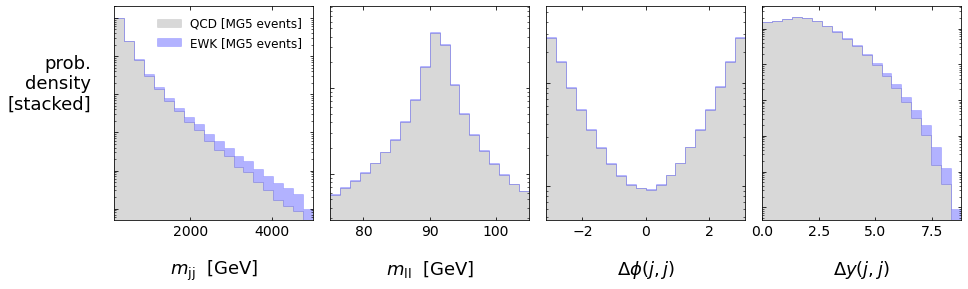

In [53]:
#  Plot Asimov in total fiducial phase space

fig = plt.figure(figsize=(12, 3))
    
for idx, obs in enumerate(observables_order) :
    ax = fig.add_axes([idx*0.25, 0, 0.23, 0.99])
    ax.tick_params(which="both", direction="in", right=True, top=True, labelsize=14)
    legend = True if idx == 0 else False
    z_QCD , ez_QCD  = plot_observable_on_axis (ax, obs, observables_QCD, weights_QCD, keys=data_table_QCD.keys, bins=20, normed=data_table_QCD.xsec_per_event, ebar=False, color="grey", label="QCD [MG5 events]", legend=legend)
    z_EWK , ez_EWK  = plot_observable_on_axis (ax, obs, observables_EWK, weights_EWK, keys=data_table_EWK.keys, bins=20, normed=data_table_EWK.xsec_per_event, ebar=False, color="blue", lower=z_QCD, label="EWK [MG5 events]", legend=legend)
    
    ax.set_ylim(0.5*np.min([z for z in z_QCD+z_EWK if z > 0]), 2*np.max(z_QCD+z_EWK))
    ax.set_yscale("log")
    ax.yaxis.set_ticklabels([])
    
    if idx == 0 :
        ax.set_ylabel("prob.\ndensity\n[stacked]", ha="right", labelpad=20, rotation=0, fontsize=18)
        
    ax.set_xlabel(observables_labels[obs], labelpad=20, rotation=0, fontsize=18)
    
plt.subplots_adjust(wspace=0.3)
plt.savefig("figures/obs_dist.pdf", bbox_inches="tight")
plt.show()


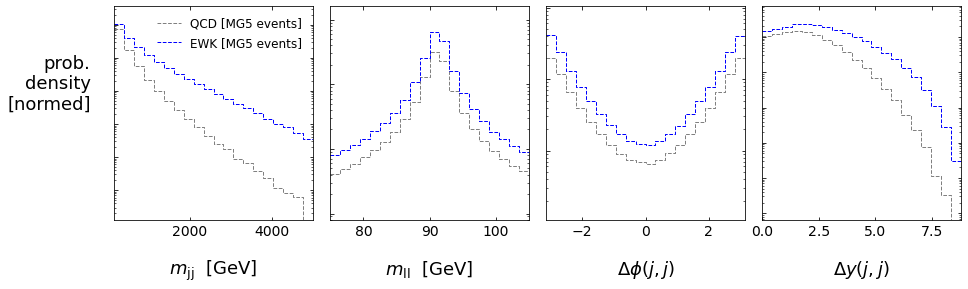

In [120]:
#  Plot Asimov in total fiducial phase space

fig = plt.figure(figsize=(12, 3))
    
for idx, obs in enumerate(observables_order) :
    ax = fig.add_axes([idx*0.25, 0, 0.23, 0.99])
    ax.tick_params(which="both", direction="in", right=True, top=True, labelsize=14)
    legend = True if idx == 0 else False
    z_QCD , ez_QCD  = plot_observable_on_axis (ax, obs, observables_QCD, weights_QCD, keys=data_table_QCD.keys, bins=20, ebar=False, color="grey", label="QCD [MG5 events]", legend=legend, fill=False)
    z_EWK , ez_EWK  = plot_observable_on_axis (ax, obs, observables_EWK, weights_EWK, keys=data_table_EWK.keys, bins=20, ebar=False, color="blue", lower=z_QCD, label="EWK [MG5 events]", legend=legend, fill=False)
    
    ax.set_ylim(0.2*np.min([z for z in np.concatenate([z_QCD,z_EWK]) if z > 0]), 5*np.max(np.concatenate([z_QCD,z_EWK])))
    ax.set_yscale("log")
    ax.yaxis.set_ticklabels([])
    
    if idx == 0 :
        ax.set_ylabel("prob.\ndensity\n[normed]", ha="right", labelpad=20, rotation=0, fontsize=18)
        
    ax.set_xlabel(observables_labels[obs], labelpad=20, rotation=0, fontsize=18)
    
plt.subplots_adjust(wspace=0.3)
plt.savefig("figures/obs_dist_normed.pdf", bbox_inches="tight")
plt.show()


In [121]:
#  Plot the datapoints provided
#
def plot_ratio_on_axis (ax, datapoints1, datapoints2, weights1, weights2) :
        
    filtered_datapoints1, filtered_weights1 = datapoints1, weights1 / np.sum(weights1)
    filtered_datapoints2, filtered_weights2 = datapoints2, weights2 / np.sum(weights2)
        
    obs_idx  = 2
    obs_lims = observable_limits["Dphi_j_j"]
    bins     = np.linspace(obs_lims[0], obs_lims[1], 21)
    
    data_x, data_z1, data_ez1 = bin_data_1D(filtered_datapoints1[:,obs_idx], bins, filtered_weights1, as_lines=True, normed=False)
    _     , data_z2, data_ez2 = bin_data_1D(filtered_datapoints2[:,obs_idx], bins, filtered_weights2, as_lines=True, normed=False)
    
    data_z1, data_z2 = np.nan_to_num(data_z1), np.nan_to_num(data_z2)

    data_z1_n, data_ez1_n = data_z1 / data_z1, data_ez1 / data_z1
    data_z2_n, data_ez2_n = data_z2 / data_z1, data_ez2 / data_z1
    
    ax.plot(data_x, data_z1_n, "-" , c="k")
    ax.fill_between(data_x, data_z1_n-data_ez1_n, data_z1_n+data_ez1_n, color="k", alpha=0.2)
    
    ax.plot(data_x, data_z2_n, "--", c="b", label=r"${\tilde c}_W=0.4$")
    ax.fill_between(data_x, data_z2_n-data_ez2_n, data_z2_n+data_ez2_n, color="b", alpha=0.2)
    
                    

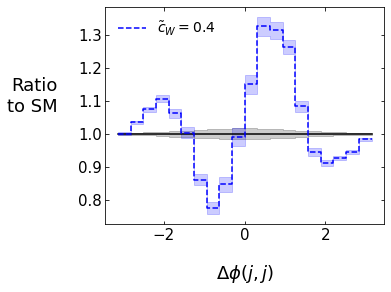

In [122]:

fig = plt.figure(figsize=(5, 4))
ax  = fig.add_subplot(1, 1, 1)
plot_ratio_on_axis(ax, observables_EWK, observables_cWtil,
                       weights_EWK    , weights_cWtil    )

ax.tick_params(which="both", direction="in", right=True, top=True, labelsize=15)

ax.set_ylabel("Ratio\nto SM", ha="right", labelpad=20, rotation=0, fontsize=18)
ax.set_xlabel(observables_labels["Dphi_j_j"], labelpad=20, rotation=0, fontsize=18)
ax.legend(loc="upper left", fontsize=14, frameon=False)

plt.savefig("figures/cWtil_dphi.pdf", bbox_inches="tight")
plt.show()
